In [79]:
# Basic module
import numpy as np
import pandas as pd

# Graphic module
import matplotlib.pyplot as plt
import seaborn as sns

# Chi-Square module
from scipy.stats import chi2, chi2_contingency, pointbiserialr  # Not exist in basic anaconda. Install need(pip install scipy or conda install scipy)
from scipy.stats.contingency import association

## Summary

상관관계 및 컬럼 유사성을 기반으로 한 그룹화 레이블 컬럼 생성

yes/no 데이터들에 대한 레이블 컬럼 - 해지 상관관계 확인

## Data loading
### Load

In [2]:
labeled_data = pd.read_csv("./result_data/labeling_data.csv", header=0, index_col=0, encoding='utf-8')

### Pre-processing


In [3]:
# Joined 상태 Stayed로 변경
labeled_data_cp = labeled_data.copy()

labeled_data_cp['Customer Status'][labeled_data_cp['Customer Status'] == 'Joined'] = 'Stayed'

C:\Users\La_Elya\AppData\Local\Temp\ipykernel_19324\2752292322.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_data_cp['Customer Status'][labeled_data_cp['Customer Status'] == 'Joined'] = 'Stayed'


## Simple Count - Corr

In [16]:
# Y/N 범주형 데이터들 그룹화
addition_service_group = ['Online Security','Premium Tech Support','Online Backup','Device Protection Plan']
age_group = ['Senior Citizen','Under 30']
family_group = ['Dependents', 'Married', 'Referred a Friend']
streaming_group = ['Streaming TV', 'Streaming Movies', 'Streaming Music']

group_name = [addition_service_group, age_group, family_group, streaming_group]
group_name_str = ['addition_service_group', 'age_group', 'family_group', 'streaming_group']

In [23]:
# 각 그룹에 대해서, yes 갯수 확인하여 새 df에 입력하는 함수
def two_selection(group_name, column_name:str):
    """
    Input : Group Name, List, elements=grouping name string
    Output : one-column Dataframe
    """
    data_df = labeled_data_cp[group_name]
    result_df = pd.DataFrame(columns=[column_name])
    
    for i in range(len(data_df)):
        if data_df.loc[i].value_counts().sort_index(ascending=False).index[0] == 'No': # 값에 no밖에 없으면, idx0에 No가 오게 됨
            result_df.loc[i+1] = 0  # 갯수가 0
        else:
            result_df.loc[i+1] = data_df.loc[i].value_counts().sort_index(ascending=False)[0]  # 그 외에는 Yes값
    
    return result_df

In [24]:
for names, column_name in zip(group_name, group_name_str):
    globals()[str(column_name)+'_df'] = two_selection(names, column_name)  # 동적 변수 사용하여 모든 그룹에 대하여 yes 수량 세기

In [110]:
tmp_df_01 = pd.concat([addition_service_group_df, age_group_df], axis=1)
tmp_df_02 = pd.concat([family_group_df, streaming_group_df], axis=1)
counting_df = pd.concat([tmp_df_01, tmp_df_02], axis=1)
counting_df.reset_index(drop=True, inplace=True)  # 전체 합산 후, idx 초기화
# 함수 설정으로 인하여, 1번부터 시작함. 따라서 초기화

In [148]:
counting_df = pd.concat([counting_df, labeled_data_cp['Churn Label_label']], axis=1)
counting_df

,addition_service_group,age_group,family_group,streaming_group,Churn Label_label,Churn Label_label
0,1,1,0,1,1,1
1,1,1,3,0,1,1
2,0,1,1,3,1,1
3,2,1,3,2,1,1
4,0,1,3,0,1,1
...,...,...,...,...,...,...
7038,0,0,0,0,0,0
7039,3,0,3,3,0,0
7040,2,0,3,3,0,0
7041,1,0,3,0,0,0


In [113]:
# 단순 상관 계수 확인
counting_df.corr()

,addition_service_group,age_group,family_group,streaming_group,Churn Label_label
addition_service_group,1.000000,0.027209,0.174644,0.467982,-0.173061
age_group,0.027209,1.000000,-0.015523,0.054826,0.070409
family_group,0.174644,-0.015523,1.000000,0.082659,-0.211326
streaming_group,0.467982,0.054826,0.082659,1.000000,0.065970
Churn Label_label,-0.173061,0.070409,-0.211326,0.065970,1.000000


In [116]:
# 개수에 대해서, Churn이 범주형이기 때문에 카이제곱 계산

chi_result = pd.DataFrame(columns=['Column', 'Chi-SQ', 'P-value(0.05)', 'H0/H1', 'Corr'])  # 컬럼명, 카이제곱값, p값, 독립/상관 여부, 상관계수
# 카이제곱값이 클수록 예측결과와 실제 결과가 다름을 의미하며, 유의미한 관련성을 가짐
# alpha는 0.05로 작성

for col_name in group_name_str:
    ct_result = pd.crosstab(counting_df[str(col_name)], counting_df['Churn Label_label'])

    chi, p, dof, expected = chi2_contingency(ct_result)

    if p < 0.05:
        R_h0 = '상관'
    else:
        R_h0 = '독립'

    if len(ct_result) > 2:  # crosstab 결과로, 어느 축이든 변수가 2개 이상이면 Cramer-V 로 상관 계수를 구함
        corr_value = association(ct_result, method='cramer')
    else:  # x/y 축 모두 변수가 2개이면, phi corr로 상관 계수를 구함
        corr_value = counting_df[str(col_name)].corr(counting_df['Churn Label_label'])

    chi_result.loc[len(chi_result)] = [col_name, chi, p, R_h0, corr_value]

chi_result

,Column,Chi-SQ,P-value(0.05),H0/H1,Corr
0,addition_service_group,338.965421,4.229357e-72,상관,0.219381
1,age_group,34.584109,4.082252e-09,상관,0.070409
2,family_group,441.476942,2.290207e-95,상관,0.250366
3,streaming_group,115.631327,6.732286e-25,상관,0.128132


## Single Group 확인
각 그룹에 대하여 카테고리화 및 계산

- 개별 서비스가 아닌, 서비스들의 조합이 해지율에 어느 영향이 있는지 확인하기 위함
- 유저별 가입 서비스 카테고리화 > 각 카테고리별 해지율 확인 방식

## Service category

In [123]:
# 서비스 카테고리화
add_service_df = pd.DataFrame(columns=['service_category'])
target_df = labeled_data_cp[addition_service_group]
category = ['A','B','C','D']
# ['Online Security','Premium Tech Support','Online Backup','Device Protection Plan']

for i in range(len(target_df)):
    lv = ''
    checked_line = target_df.loc[i]
    for idx, j in enumerate(addition_service_group):
        if checked_line[j] == 'Yes':
            lv += category[idx]
    
    if lv == '':
        add_service_df.loc[i+1] = 'None'
    else:
        add_service_df.loc[i+1] = lv

add_service_df.reset_index(drop=True, inplace=True)

# add_service_df

In [144]:
service_category_churned =  pd.concat([add_service_df, labeled_data_cp['Customer Status']], axis=1)
service_category_churned

,service_category,Customer Status
0,D,Churned
1,C,Churned
2,None,Churned
3,CD,Churned
4,None,Churned
...,...,...
7038,None,Stayed
7039,ABD,Stayed
7040,CD,Stayed
7041,A,Stayed


In [145]:
# 해지율 계산
scc_ct = pd.crosstab(service_category_churned['service_category'], service_category_churned['Customer Status'])
scc_ct['Total'] = scc_ct['Churned'] + scc_ct['Stayed']
scc_ct['Churned_Percent'] = round(scc_ct['Churned']/scc_ct['Total']*100, 4)
scc_ct.sort_values('Churned_Percent')
# 이렇게 계산하면, total이 늘어날 수록, 해지율을 떨어지는 이슈가 있다.

Customer Status,Churned,Stayed,Total,Churned_Percent
service_category,,,,
ABCD,25,445,470,5.3191
ABC,22,197,219,10.0457
ABD,26,217,243,10.6996
ACD,30,193,223,13.4529
BCD,39,217,256,15.2344
AB,26,141,167,15.5689
AD,32,143,175,18.2857
BC,40,167,207,19.3237
AC,42,172,214,19.6262


<Axes: xlabel='service_category', ylabel='Churned_Percent'>

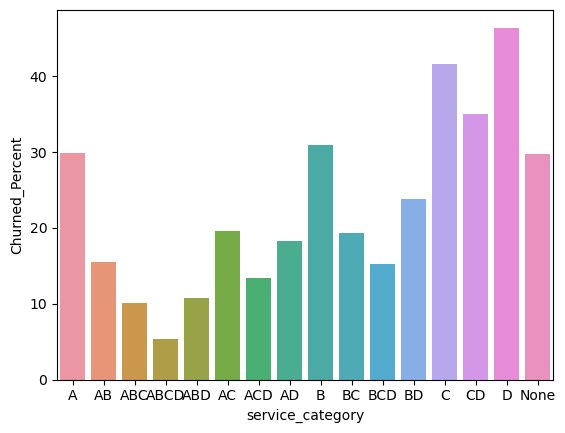

In [120]:
# 해지율 시각화
sns.barplot(scc_ct, x=scc_ct.index, y='Churned_Percent')

In [122]:
# Cramer's V 값 계산
# Cramer's V는 범주형 데이터간의 상관 계수를 구하는 공식이다.
# 다만, x/y축 둘 중 하나라도 3개 이상의 변수를 가져야하며, 2x2 범주형 데이터의 경우는 phi를 사용한다
# phi : 범주형 데이터의 스피어만 상관계수 구하기
test_ctdf = pd.crosstab(service_category_churned['service_category'], service_category_churned['Customer Status'])
rows = [row.to_list() for i, row in test_ctdf.iterrows()]
association(rows, method="cramer")

0.24204183183661673

## Age

In [124]:
age_df = pd.DataFrame(columns=['Age_category'])
target_df = labeled_data_cp[age_group]
category = ['Senior','U-30','Normal']
# ['Senior Citizen','Under 30']

for i in range(len(target_df)):
    lv = ''
    checked_line = target_df.loc[i]
    for idx, j in enumerate(age_group):
        if checked_line[j] == 'Yes':
            lv += category[idx]
    
    if lv == '':
        age_df.loc[i+1] = category[2]
    else:
        age_df.loc[i+1] = lv

age_df.reset_index(drop=True, inplace=True)

age_df

,Age_category
0,Senior
1,Senior
2,Senior
3,Senior
4,Senior
...,...
7038,Normal
7039,Normal
7040,Normal
7041,Normal


In [125]:
Age_category_churned =  pd.concat([age_df, labeled_data_cp['Customer Status']], axis=1)
Age_category_churned

,Age_category,Customer Status
0,Senior,Churned
1,Senior,Churned
2,Senior,Churned
3,Senior,Churned
4,Senior,Churned
...,...,...
7038,Normal,Stayed
7039,Normal,Stayed
7040,Normal,Stayed
7041,Normal,Stayed


In [127]:
acc_ct = pd.crosstab(Age_category_churned['Age_category'], Age_category_churned['Customer Status'])
acc_ct['Total'] = acc_ct['Churned'] + acc_ct['Stayed']
acc_ct['Churned_Percent'] = round(acc_ct['Churned']/acc_ct['Total']*100, 4)
acc_ct.sort_values('Churned_Percent')
# 이렇게 계산하면, total이 늘어날 수록, 해지율을 떨어지는 이슈가 있다.

Customer Status,Churned,Stayed,Total,Churned_Percent
Age_category,,,,
U-30,304,1097,1401,21.6988
Normal,1089,3411,4500,24.2000
Senior,476,666,1142,41.6813


<Axes: xlabel='Age_category', ylabel='Churned_Percent'>

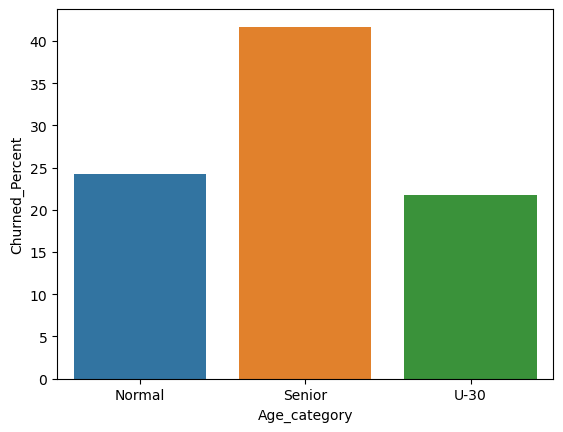

In [128]:
sns.barplot(acc_ct, x=acc_ct.index, y='Churned_Percent')

In [129]:
test_ctdf = pd.crosstab(Age_category_churned['Age_category'], Age_category_churned['Customer Status'])
rows = [row.to_list() for i, row in test_ctdf.iterrows()]
association(rows, method="cramer")

0.1524938917940296

## Family_group

In [131]:
family_df = pd.DataFrame(columns=['Family_category'])
target_df = labeled_data_cp[family_group]
category = ['A', 'B', 'C']
# ['Dependents', 'Married', 'Referred a Friend']

for i in range(len(target_df)):
    lv = ''
    checked_line = target_df.loc[i]
    for idx, j in enumerate(family_group):
        if checked_line[j] == 'Yes':
            lv += category[idx]
    
    if lv == '':
        family_df.loc[i+1] = 'None'
    else:
        family_df.loc[i+1] = lv

family_df.reset_index(drop=True, inplace=True)

family_df

,Family_category
0,None
1,ABC
2,A
3,ABC
4,ABC
...,...
7038,None
7039,ABC
7040,ABC
7041,ABC


In [132]:
family_category_churned =  pd.concat([family_df, labeled_data_cp['Customer Status']], axis=1)
family_category_churned

,Family_category,Customer Status
0,None,Churned
1,ABC,Churned
2,A,Churned
3,ABC,Churned
4,ABC,Churned
...,...,...
7038,None,Stayed
7039,ABC,Stayed
7040,ABC,Stayed
7041,ABC,Stayed


In [133]:
fcc_ct = pd.crosstab(family_category_churned['Family_category'], family_category_churned['Customer Status'])
fcc_ct['Total'] = fcc_ct['Churned'] + fcc_ct['Stayed']
fcc_ct['Churned_Percent'] = round(fcc_ct['Churned']/fcc_ct['Total']*100, 4)
fcc_ct.sort_values('Churned_Percent')
# 이렇게 계산하면, total이 늘어날 수록, 해지율을 떨어지는 이슈가 있다.

Customer Status,Churned,Stayed,Total,Churned_Percent
Family_category,,,,
ABC,51,1206,1257,4.0573
AB,5,63,68,7.3529
A,50,252,302,16.5563
BC,573,1392,1965,29.1603
None,1150,2189,3339,34.4414
B,40,72,112,35.7143


<Axes: xlabel='Family_category', ylabel='Churned_Percent'>

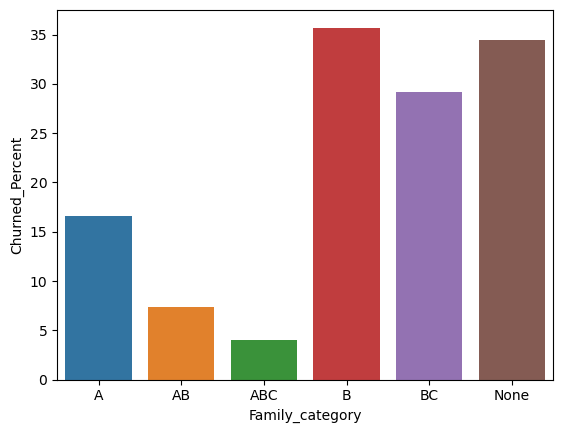

In [134]:
sns.barplot(fcc_ct, x=fcc_ct.index, y='Churned_Percent')

In [136]:
test_ctdf = pd.crosstab(family_category_churned['Family_category'], family_category_churned['Customer Status'])
rows = [row.to_list() for i, row in test_ctdf.iterrows()]
association(rows, method="cramer")

0.25912067415735085

## Streaming Group

In [137]:
streaming_df = pd.DataFrame(columns=['Streaming_category'])
target_df = labeled_data_cp[streaming_group]
category = ['A','B','C']
# ['Streaming TV', 'Streaming Movies', 'Streaming Music']

for i in range(len(target_df)):
    lv = ''
    checked_line = target_df.loc[i]
    for idx, j in enumerate(streaming_group):
        if checked_line[j] == 'Yes':
            lv += category[idx]
    
    if lv == '':
        streaming_df.loc[i+1] = 'None'
    else:
        streaming_df.loc[i+1] = lv

streaming_df.reset_index(drop=True, inplace=True)

streaming_df

,Streaming_category
0,B
1,None
2,ABC
3,AB
4,None
...,...
7038,None
7039,ABC
7040,ABC
7041,None


In [138]:
streaming_category_churned =  pd.concat([streaming_df, labeled_data_cp['Customer Status']], axis=1)
streaming_category_churned

,Streaming_category,Customer Status
0,B,Churned
1,None,Churned
2,ABC,Churned
3,AB,Churned
4,None,Churned
...,...,...
7038,None,Stayed
7039,ABC,Stayed
7040,ABC,Stayed
7041,None,Stayed


In [139]:
scc_ct = pd.crosstab(streaming_category_churned['Streaming_category'], streaming_category_churned['Customer Status'])
scc_ct['Total'] = scc_ct['Churned'] + scc_ct['Stayed']
scc_ct['Churned_Percent'] = round(scc_ct['Churned']/scc_ct['Total']*100, 4)
scc_ct.sort_values('Churned_Percent')
# 이렇게 계산하면, total이 늘어날 수록, 해지율을 떨어지는 이슈가 있다.

Customer Status,Churned,Stayed,Total,Churned_Percent
Streaming_category,,,,
None,744,2701,3445,21.5965
ABC,450,1220,1670,26.9461
BC,191,496,687,27.8020
A,220,515,735,29.9320
AB,121,149,270,44.8148
B,56,49,105,53.3333
C,64,35,99,64.6465
AC,23,9,32,71.8750


<Axes: xlabel='Streaming_category', ylabel='Churned_Percent'>

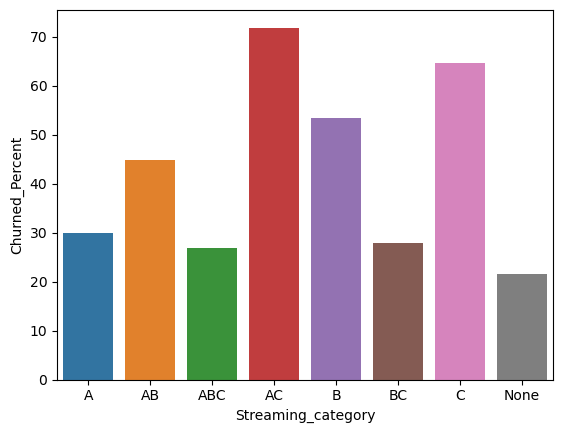

In [140]:
sns.barplot(scc_ct, x=scc_ct.index, y='Churned_Percent')

In [141]:
test_ctdf = pd.crosstab(streaming_category_churned['Streaming_category'], streaming_category_churned['Customer Status'])
rows = [row.to_list() for i, row in test_ctdf.iterrows()]
association(rows, method="cramer")

0.18483725048435132

# Testing

In [ ]:
labeled_data_cp[addition_service_group].loc[0]['Online Security']

'No'

In [77]:
# pd.crosstab(test['service_category'], test['Customer Status'])
pd.crosstab(test['Customer Status'], test['service_category'])
chi, p, dof, expected = chi2_contingency(pd.crosstab(test['service_category'], test['Customer Status']))
chi, p, dof, expected, pd.crosstab(test['service_category'], test['Customer Status'])

(412.6088611912049,
 1.5457186593036639e-78,
 15,
 array([[  81.7339202 ,  226.2660798 ],
        [  44.31676842,  122.68323158],
        [  58.1160017 ,  160.8839983 ],
        [ 124.72383927,  345.27616073],
        [  64.4848786 ,  178.5151214 ],
        [  56.78915235,  157.21084765],
        [  59.17748119,  163.82251881],
        [  46.43972739,  128.56027261],
        [  64.21950873,  177.78049127],
        [  54.93156325,  152.06843675],
        [  67.93468692,  188.06531308],
        [  63.68876899,  176.31123101],
        [ 124.98920914,  346.01079086],
        [  97.92148232,  271.07851768],
        [ 118.35496237,  327.64503763],
        [ 741.17804913, 2051.82195087]]),
 Customer Status   Churned  Stayed
 service_category                 
 A                      92     216
 AB                     26     141
 ABC                    22     197
 ABCD                   25     445
 ABD                    26     217
 AC                     42     172
 ACD                    30  

In [ ]:
addition_service_label = labeled_data_cp[['Online Security','Premium Tech Support','Online Backup','Device Protection Plan']]

In [ ]:
addition_service_label.loc[2].value_counts().sort_index(ascending=False)

No    4
Name: 2, dtype: int64

In [ ]:
test = pd.DataFrame(columns=['addition_service'])

for i in range(len(addition_service_label)):
    if addition_service_label.loc[i].value_counts().sort_index(ascending=False).index[0] == 'No':
        test.loc[i+1] = 0
    else:
        test.loc[i+1] = addition_service_label.loc[i].value_counts().sort_index(ascending=False)[0]

test.reset_index(drop=True)

,addition_service
0,1
1,1
2,0
3,2
4,0
...,...
7038,0
7039,3
7040,2
7041,1
